<a href="https://colab.research.google.com/github/mahmoudmastouri/Portfolio-Risk-in-Multiple-Frequencie/blob/master/01_Markowitz_bullet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Portfolio Risk in Multiple frequencies (part I)

# General Definitions and functions

In [ ]:
!pip3 install yfinance

In [ ]:
import numpy as np
# There's an issue with pandas_datareader while working on collab
#import pandas_datareader as pdr
import yfinance as yf
import datetime as dt
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
%matplotlib inline

In [ ]:
def prepare_portfolio(tickers,start,end = None):
    returns = pd.DataFrame()
    for ticker in tickers:
      end = end if end != None else dt.datetime.now().strftime("%Y-%m-%d")
      data = yf.download(ticker, start = start, end=end)
      data = pd.DataFrame(data)
      data[ticker] = data['Adj Close'].pct_change()
      if returns.empty:
          returns = data[[ticker]]
      else:
          returns = returns.join(data[[ticker]], how = 'outer' )
    return returns

# Portfilio Return and Risk

## Gather data

In [ ]:
tickers = ["AAPL", "JPM", "WMT", "TGT", "MSFT", "AMGN", "^NDX", "SPY"]
start = dt.datetime(2015,1,1).strftime("%Y-%m-%d")
end = dt.datetime(2020,12,12).strftime("%Y-%m-%d")
daily_returns = prepare_portfolio(tickers, start, end)
daily_returns = daily_returns.dropna()

## Generating Random portfolios

### Define Mean and covariance and return

$ R_p = $<b>q$^TR$</b> $= \sum_{i=1}^{n}{q_iR_i}$</br>
$ q = [ q_1, q_2, ..., q_N]^T$,  q~N(0,1) </br>
$ \mu_p = E[R_p] = q^TE[R] = q^T\mu $</br>
$ σ_p^2 = E[R_p^2] - μ_p^2 = q^T Σ^TCΣq$

In [ ]:
mu = np.array(np.mean(daily_returns))
n_portfolios = 10000
n_assets = len(tickers)
N = daily_returns.shape[1]
ones = np.ones((N,))
C = daily_returns.corr(method='pearson')
#reset symbol as index (rather than 0-X)
C.head().reset_index()
qs = np.array([  np.random.normal(0, 1, n_assets) for _ in range(n_portfolios) ])
mu_p = qs @ mu
Sigma = np.diag(np.std(daily_returns))
simga_p = np.array([ qs[i,:] @ Sigma.T @ C @ Sigma @ (qs[i,:]).T for i in range(n_portfolios)])
sharpe_arr = mu_p/simga_p

### Draw return-risk plot

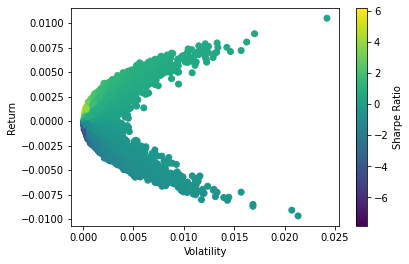

In [ ]:
plt.figure()
plt.scatter(simga_p, mu_p, c=sharpe_arr, cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.show()

# Portfolio optimization with risk

## Calculation of  q∗  for each portfolio

$ q^* = 
\frac{ 
  \begin{bmatrix}
    μ & \boldsymbol{1^TC^{-1}\mu}\\
    1 & \boldsymbol{1^TC^{-1}1}
\end{bmatrix} \boldsymbol{C^{-1}\mu} +
\begin{bmatrix}
    \boldsymbol{μ^TC^{-1}μ} & \mu \\
    \boldsymbol{μ^TC^{-1}1} & 1
\end{bmatrix} \boldsymbol{C^{-1}1} 
}{
\begin{bmatrix}
    \boldsymbol{μ^TC^{-1}μ} & \boldsymbol{1^TC^{-1}\mu} \\
    \boldsymbol{μ^TC^{-1}1} & \boldsymbol{1^TC^{-1}1}
\end{bmatrix}
} $

In [ ]:
# orig
q_stars = []
for i in range(n_portfolios):
  first = np.linalg.det([[mu_p[i], ones.T@np.linalg.inv(C)@mu], [1, ones.T@np.linalg.inv(C)@ones]])
  second = np.linalg.det([ [mu.T@np.linalg.inv(C)@mu, mu_p[i]], [mu.T@np.linalg.inv(C)@ones, 1] ])
  third = np.linalg.det([ [mu.T@np.linalg.inv(C)@mu, ones.T@np.linalg.inv(C)@mu], [mu.T@np.linalg.inv(C)@ones, ones.T@np.linalg.inv(C)@ones] ])
  q_star = ( first*np.linalg.inv(C)@mu + second*np.linalg.inv(C)@ones)/third
  q_stars.append(q_star)
q_stars = np.array(q_stars)

## Calculation of return and risk after optimization 

In [ ]:
mu_p_opt = q_stars @ mu
simga_p_opt = np.array([ q_stars[i,:] @ Sigma.T @ C @ Sigma @ (q_stars[i,:]).T for i in range(n_portfolios)])
sharpe_arr_opt = mu_p_opt/simga_p_opt

## Draw Markowitz bullet

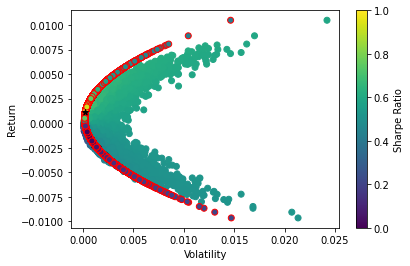

In [ ]:
max_sr_vol_opt = simga_p_opt[sharpe_arr_opt.argmax()]
max_sr_ret_opt = mu_p_opt[sharpe_arr_opt.argmax()]

plt.figure()
plt.scatter(simga_p, mu_p, c=sharpe_arr, cmap='viridis')
#plt.scatter(simga_p_opt, mu_p_opt, c='red', cmap='viridis')
plt.scatter(simga_p_opt, mu_p_opt, c=sharpe_arr_opt, edgecolors='red', cmap='viridis')
# c=colors[i],edgecolors='black'
plt.scatter(max_sr_vol_opt, max_sr_ret_opt, c='black', marker="*")
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.show()